In [3]:
# %load ../src/genetic.py
"""
Fast, parallelizable genetic algorithm implementation with some shortcuts.

Numpy array naming convention:
- *_ids = array of number corresponding to rows in the dataset
- *_index = boolean array allowing for fast selection from the dataset
"""

import pandas as pd
import numpy as np
np.random.seed(420)

from sklearn.svm import SVR
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import r2_score

from tqdm import trange
from numba import jit
import click

import multiprocessing as mp
import pickle
from itertools import repeat
from pathlib import Path
from datetime import datetime
from typing import NamedTuple, List, Tuple


class DataSet(NamedTuple):
    X: np.array  # (n_samples, n_features)
    y: np.array  # 1d
    ids: np.array  # 1d


class GenerationParams(NamedTuple):
    n_models: int
    train_ids: np.array  # (n_models, n_train_samples)
    n_fits: int  # per each model during hyperparameter optimization
    train_data: DataSet
    n_train_samples: int
    train_probs: np.array
    valid_data: DataSet
    valid_index: np.array
    mutation_prob: float
    score_mode: str

class FitParams(NamedTuple):
    train_index: np.array # 1d train_size
    n_fits: int
    train_data: DataSet
    valid_data: DataSet
    valid_index: np.array


class FitResult(NamedTuple):
    train_index: np.array
    model_pred: np.array
    model_score: float
    model_params: dict


class MutationParams(NamedTuple):
    pair: np.array
    train_probs: np.array
    mutation_prob: float


class GenerationResult(NamedTuple):
    train_probs: np.array
    # train_index: np.array  # (n_samples), True for samples that were used in any of the models
    model_scores: np.array
    model_params: List[dict]
    model_samples: np.array  # (n_models, n_train_samples) - IDs, NOT INDEX


class EvolutionParams(NamedTuple):
    n_models: int  # = datasets per generation
    n_fits: int  # per each model during hyperparameter optimization
    n_generations: int
    n_train_samples: int
    n_valid_samples: int
    train_ids: np.array
    mutation_prob: float  # between 0 and 1
    score_mode: str


# defaults for random hyperparameter search
params_dict = {
    'kernel': ['rbf'],
    'gamma': [1 / i for i in range(60, 130, 20)],
    'C': [0.9, 1.0, 1.1],
    'epsilon': [1e-2, 3e-2, 5e-2],
    'shrinking': [True]
}


def sample(n_samples: int, ids: np.array, weights: np.array=None) -> np.array:
    selected_ids = np.random.choice(ids, n_samples, replace=False, p=weights)
    selected_index = np.isin(ids, selected_ids, assume_unique=True)
    return selected_index  # same shape as ids, for easier selection


def fit_svr(
        X_train: np.array,
        y_train: np.array,
        X_valid: np.array,
        y_valid: np.array,
        params_dict: dict=params_dict,
        n_iter: int=25
):
    ps = ParameterSampler(n_iter=n_iter, param_distributions=params_dict)
    scores = np.zeros(n_iter)
    models = list(repeat(None, n_iter))
    for idx, params in enumerate(ps):
        svr = SVR(**params)
        svr.fit(X_train, y_train)
        scores[idx] = r2_score(y_valid, svr.predict(X_valid))
        models[idx] = svr
    return models[np.argmax(scores)]


def fit_thread(params: GenerationParams) -> FitResult:
    model = fit_svr(
        params.train_data.X[params.train_index],
        params.train_data.y[params.train_index],
        params.valid_data.X[params.valid_index],
        params.valid_data.y[params.valid_index],
        n_iter=params.n_fits
    )
    model_pred = model.predict(params.train_data.X)
    model_score = r2_score(
        params.valid_data.y[params.valid_index],
        model.predict(params.valid_data.X[params.valid_index])
    )
    return FitResult(params.train_index, model_pred, model_score, model.get_params())


def crossover_thread(params: MutationParams):
    intersection = np.intersect1d(params.pair[0], params.pair[1])
    rest = np.setxor1d(params.pair[0], params.pair[1])
    if len(rest) == 0:
        new_ids = intersection
    else:
        other = np.random.choice(
            rest, len(params.pair[0]) - len(intersection), replace=False,
        )
        new_ids = np.concatenate([intersection, other])
    assert len(new_ids) == len(params.pair[0])
    # Mutation
    np.random.shuffle(new_ids)
    survival_boundary = round(len(new_ids) * params.mutation_prob)
    chosen = new_ids[:-survival_boundary]
    params.train_probs[chosen.astype(np.int)] = 0
    assert params.train_probs[chosen.astype(np.int)].sum() == 0
    adjusted_params = params.train_probs / params.train_probs.sum()
    assert adjusted_params[chosen.astype(np.int)].sum() == 0
    supplied = np.random.choice(
        np.arange(len(params.train_probs)),
        size=survival_boundary,
        replace=False,
        p=adjusted_params
    )
    result = np.concatenate([chosen, supplied])
    assert len(result) == params.pair.shape[1]
    return result.astype(np.int)


def select_best(model_scores):
    normalized_scores = model_scores / np.sum(model_scores)
    sorted_order = np.argsort(-normalized_scores)  # sort by DESCENDING SCORE
    cum_scores = np.cumsum(normalized_scores[sorted_order])
    fitness_threshold = (np.random.random() / cum_scores[1]) + cum_scores[1]
    fit_scores = cum_scores < fitness_threshold
    return sorted_order[fit_scores]


def calculate_probs(models_pred: np.array, mode: str, y: np.array=None):
    if mode == "variance":
        train_var = models_pred.var(axis=0)
        assert len(train_var) == models_pred.shape[1]
        scores = train_var
    elif mode == "loss":
        if y is None:
            raise AttributeError(f"y can't be None when using 'loss' mode")
        loss = np.subtract(models_pred, y.reshape(1, -1)) ** 2
        scores = loss.mean(axis=0)
    else:
        raise AttributeError(f"No such method: {mode}")

    exploded_scores = np.exp(scores)

    # zeroout prob of half of the samples that were predicted correctly
    sorted_order_ids = np.argsort(exploded_scores)  # sort by ASCENDING SCORE
    cum_scores = np.cumsum(exploded_scores[sorted_order_ids])
    unfit_index = (cum_scores / cum_scores[-1]) < 0.5  # eliminate most accurately predicted samples
    exploded_scores[sorted_order_ids[unfit_index]] = 0

    normalized_scores = exploded_scores / exploded_scores.sum()
    return normalized_scores


def run_generation(params: GenerationParams, pool: mp.Pool) -> (GenerationParams, GenerationResult):
    models_pred = np.zeros((params.n_models, len(params.train_probs)))
    model_params = list(repeat({}, params.n_models))
    model_scores = np.zeros(params.n_models)
    model_samples = np.zeros((params.n_models, params.n_train_samples))

    fit_params = [FitParams(
        train_index=params.train_ids[i],
        n_fits=params.n_fits,
        train_data=params.train_data,
        valid_data=params.valid_data,
        valid_index=params.valid_index,
    ) for i in range(len(params.train_ids))]

    results = pool.map(fit_thread, fit_params)
    for idx, fit_result in enumerate(results):
        models_pred[idx] = fit_result.model_pred
        model_params[idx] = fit_result.model_params
        model_scores[idx] = fit_result.model_score
        model_samples[idx] = params.train_data.ids[fit_result.train_index].astype(np.uint)

    chosen_samples = model_samples[select_best(model_scores)]
    comb = np.random.randint(low=0, high=len(chosen_samples), size=(params.n_models, 2))
    pairs = [chosen_samples[c] for c in comb]
    train_probs = calculate_probs(models_pred, mode=params.score_mode, y=params.train_data.y)
    crossover_param_list = [MutationParams(pair=p, train_probs=train_probs, mutation_prob=params.mutation_prob) for p in pairs]
    new_ids = pool.map(crossover_thread, crossover_param_list)

    new_params = params._replace(train_ids=np.asarray(new_ids), train_probs=train_probs)
    return new_params, GenerationResult(train_probs, model_scores, model_params, model_samples)


def run_evolution(train_data: DataSet, valid_data: DataSet, pool: mp.Pool, params: EvolutionParams):
    valid_index = sample(params.n_valid_samples, valid_data.ids)
    train_probs = np.ones(len(train_data.ids)) / len(train_data.ids)
    results = []
    if params.train_ids is None:
        train_ids = np.random.choice(
            train_data.ids,
            size=(params.n_models, params.n_train_samples),
            replace=False,
        )
    else:
        train_ids = params.train_ids

    next_gen_params = GenerationParams(
        n_models=params.n_models,
        n_fits=params.n_fits,
        train_data=train_data,
        n_train_samples=params.n_train_samples,
        train_probs=train_probs,
        valid_data=valid_data,
        valid_index=valid_index,
        mutation_prob=params.mutation_prob,
        train_ids=train_ids,
        score_mode=params.score_mode,
    )

    with trange(params.n_generations) as t:
        for generation_idx in t:
            try:
                t.set_description(f"Generation {generation_idx+1}")
                next_gen_params, gen_results = run_generation(next_gen_params, pool)
                results.append(gen_results)
                t.set_postfix(
                    mean_score=sum(gen_results.model_scores)/len(gen_results.model_scores),
                    max_score=max(gen_results.model_scores)
                )
            except KeyboardInterrupt:
                print("KeyboardInterrupt: stopping evolution...")
                break
    return results


@click.command()
@click.option("-n", "--n-threads", default=4)
@click.option("-i", "--input-dir", type=str, default='../data')
@click.option("-o", "--output-path", type=str,
              default=datetime.now().strftime('../data/genetic-%d-%m-%y-%H-%M-%S.pkl'))
def main(n_threads, input_dir, output_path):
    input_dir = Path(input_dir).resolve()
    output_path = Path(output_path).resolve()
    train_X = np.load(input_dir / 'train_X.npy')
    train_y = np.load(input_dir / 'train_y.npy')
    valid_X = np.load(input_dir / 'valid_X.npy')
    valid_y = np.load(input_dir / 'valid_y.npy')
    train_data = DataSet(train_X, train_y, np.arange(len(train_X)))
    valid_data = DataSet(valid_X, valid_y, np.arange(len(valid_X)) * (-1))
    params = EvolutionParams(
        n_models = 32,
        n_fits = 32,
        n_generations = 128,
        n_train_samples = 1500,
        n_valid_samples = 6000,
        train_ids = None,
        mutation_prob = 0.04,
        score_mode = "variance",
    )
    with mp.Pool(n_threads) as pool:
        results = run_evolution(train_data, valid_data, pool, params)
        print(f"Saving results to {output_path}...")
        pickle.dump(results, open(output_path, 'wb'))
        print("Done")


# if __name__ == '__main__':
#     main()


In [5]:
input_dir = Path('../data/')
train_X = np.load(input_dir / 'train_X.npy')
train_y = np.load(input_dir / 'train_y.npy')
valid_X = np.load(input_dir / 'valid_X.npy')
valid_y = np.load(input_dir / 'valid_y.npy')
train_data = DataSet(train_X, train_y, np.arange(len(train_X)))
valid_data = DataSet(valid_X, valid_y, np.arange(len(valid_X)) * (-1))

In [6]:
# fitting the model on validation data
model = fit_svr(valid_X, valid_y, train_X, train_y)

In [10]:
y_pred = model.predict(train_X)

In [9]:
# most of the training data is not well explained by validation features
r2_score(train_y, y_pred)

0.02438919832327191

In [37]:
# but some of the training samples are
mse = (y_pred-train_y)**2
sample_selector = mse < 1e-6
print(f"Samples matching selector: {sum(sample_selector)}")
r2_score(train_y[sample_selector], y_pred[sample_selector])

Samples matching selector: 1852


0.998830512688503

In [38]:
# so we fit the model on these samples
normal_model = fit_svr(train_X[sample_selector], train_y[sample_selector], valid_X, valid_y, n_iter=10)
r2_score(valid_y, normal_model.predict(valid_X))

0.17417106592376708

In [ ]:
# todo: this can potentially serve as a good starting point for genetic algorithm

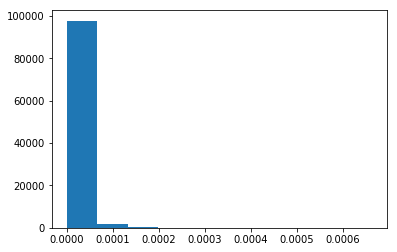

In [45]:
import matplotlib.pyplot as plt
sampling_prob = mse / sum(mse)
plt.hist(sampling_prob)
plt.show()

In [65]:
from scipy.stats import describe
describe(sampling_prob)

DescribeResult(nobs=100000, minmax=(2.1110198703677774e-17, 0.0006615211651541762), mean=9.999999999999857e-06, variance=6.262755722361359e-10, skewness=10.671713917530614, kurtosis=186.82272911289297)